In [30]:
!pip install 'plotnine[all]'
!pip install spacy
!python -m spacy download en
!pip install -U textblob
!python -m textblob.download_corpora
!pip install vaderSentiment

✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_sm')
✔ Linking successful
/usr/local/lib/python3.6/dist-packages/en_core_web_sm -->
/usr/local/lib/python3.6/dist-packages/spacy/data/en
You can now load the model via spacy.load('en')
Requirement already up-to-date: textblob in /usr/local/lib/python3.6/dist-packages (0.15.3)
[nltk_data] Downloading package brown to /root/nltk_data...
[nltk_data]   Package brown is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package conll2000 to /root/nltk_data...
[nltk_data]   Package conll2000 is alrea

In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import itertools
import nltk

from wordcloud import WordCloud,STOPWORDS
from plotnine import *
from spacy.lang.en import English
from textblob import TextBlob
from yellowbrick.classifier import PrecisionRecallCurve
from sklearn.preprocessing import LabelEncoder, OrdinalEncoder
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from nltk import ngrams
from nltk.stem import WordNetLemmatizer
from yellowbrick.draw import manual_legend
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

## DATA MINING AND MACHINE LEARNING

In [0]:
# The dataset from Kaggle:
tweets = pd.read_csv("https://raw.githubusercontent.com/SarahBuechner/DMML2019_Team_Google/master/data/Tweets.csv")

### The structure of DM & ML
- 1.0) Try our model classification -> Expected bad accuracy **TO DO**
- 1.1) Classify the tweets using TextBlob and Vader -> Accuracy 55%
- 1.2) Understand why those methods classified wrongly the tweets and create the **Major Matrix** to store the wrong classified tweets
- 1.3) Reclassified the tweets in the **Major Matrix** -> Expected better accuracy
- 1.4) Implement the whole process with train and test validation
- 1.5) If it is possible to validate the model with another dataset
- 1.6) Business model: Sort the tweets that have to be replied firstly: 
   - (i) Based on polarity (Vader index)
   - (ii) Based on verified account
   - (iii) Based on # number of followers
- 1.7) Vader and TextBlob

### 1) Using the methods seen in class

Function tokenization_tweets

The function **`tokenization_tweets`** allows the user to *tokenize* the tweet removing the *noise*:

**Tokens removed**:
*   Stop words
*   Punctuation
*   Tokens with less than 3 characters
*   Tokens containing a non alphabet character (i.e. "/", "@", etc.)
*   Empty tokens (not implemented)

Then the trailing whitespaces are removed from the token using `strip()` and finally is converted to a lowercase word using `lower()`. If after removing the not desired tokens the `filtered_tweet` is empty, we do not include it into the `list_filtered_tweets`.

**Arguments**: 
*   `list_tweets`: array containing the tweets. 
*   `number_observations`: how many observations we want to treat (it will be removed in the future but now is usefull)

In [0]:
wordnet_lemmatizer = WordNetLemmatizer()
def tokenization_tweets(tweet):
    only_letters = re.sub("[^a-zA-Z]", " ",tweet) 
    tokens = nltk.word_tokenize(only_letters)[2:]
    lower_case = [l.lower() for l in tokens]
    filtered_result = list(filter(lambda l: l not in STOPWORDS, lower_case))
    lemmas = [wordnet_lemmatizer.lemmatize(t) for t in filtered_result]
    return lemmas

In [0]:
# Saving tokens for each tweets
tweets['tokenized_tweet'] = tweets.text.apply(tokenization_tweets)

In [0]:
# Saving tokens for each tweet as a string
tweets['tokens_string'] = tweets.tokenized_tweet.apply(lambda token:' '.join(token))

In [0]:
X = tweets['tokens_string'] # the features we want to analyze, we can play with others too
y = tweets['airline_sentiment'] # the labels, or answers, we want to test against

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=72)

In [0]:
# Converting the tokens using CountVectorizer
v = CountVectorizer(analyzer = "word")

X_train = v.fit_transform(X_train)
X_test = v.transform(X_test)

# Converting the sentiment into a numerical class
encoder = LabelEncoder()
y_train = encoder.fit_transform(y_train)
y_test = encoder.fit_transform(y_test)

#### 1.1) Logistic Regression Classifier
> **Count Vectorizer:** The most straightforward one, it counts the number of times a token shows up in the document and uses this value as its weight.



#### 1.2) K Neighbors Classifier
> **KNeighborsClassifier:** classifies the tweets into different classes according to the k nearest neighbors. 
We used uniform weights, meaning that all points in each neighborhood are weighted equally.



#### 1.3) Decision Tree Classifier
> **DecisionTreeClassifier:** splits the tweets into different classes according to specific criteria.<br/>
Here we use the following default parameters: <br/>
- criterion='gini', <br/> 
To measure the quality of a split we used the Gini impurity. 
Gini impurity is a measure of how often a randomly chosen element from the set would be incorrectly labeled if it was randomly labeled according to the distribution of labels in the subset. 
- splitter='best',<br/>
To choose the split at each node we chose the best split algorithm. 
- max_depth=None,<br/>
We did not define any maximum depth.



#### 1.4) Random Forest Classifier
> **RandomForestClassifier:** fits decision trees on randomly selected sub-samples of the dataset, gets prediction from each tree and selects the best solution (improve accurary and control over-fitting) by averaging.
The sub-sample size is always the same as the original
input sample size. Here we chose to draw the samples with replacement as we set`bootstrap=True`.

In [0]:
# Creating the classifiers
classifiers = [
    LogisticRegression(C = 0.0001, solver = 'liblinear', max_iter = 200),
    KNeighborsClassifier(3),
    DecisionTreeClassifier(),
    RandomForestClassifier(n_estimators = 200)]

In [39]:
# Computing the accuracy for each classifier
accuracies=[]
models=[]

for classifier in classifiers:
  fit = classifier.fit(X_train, y_train)
  pred = fit.predict(X_test)
  accuracy = accuracy_score(pred, y_test)
  print('Accuracy of '+ classifier.__class__.__name__ + ' is ' + str(accuracy)) 

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


Accuracy of LogisticRegression is 0.6412556053811659
Accuracy of KNeighborsClassifier is 0.4944965348552792
Accuracy of DecisionTreeClassifier is 0.6746840603342845
Accuracy of RandomForestClassifier is 0.7423562984101101


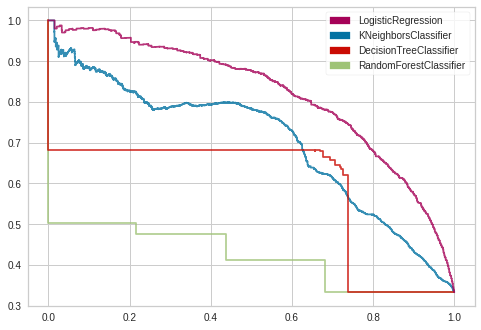

In [40]:
for classifier in classifiers:  
  viz = PrecisionRecallCurve(classifier, fill_area=False, ap_score=False)
  viz.fit(X_train, y_train)
  viz.score(X_test, y_test)
  manual_legend(viz, ('LogisticRegression', 'KNeighborsClassifier', 'DecisionTreeClassifier', 'RandomForestClassifier'), ('m', 'b', 'r', 'g'), frameon=True, loc='upper right')

### 2) Classification using TextBlob and Vader



#### 2.1) Function tweet_sentiment_analysis
The function **`tweet_sentiment_analysis`** computes the sentiment analysis of each tweet using **TextBlob** (`polarity` and `subjectivity`) and using **Vader** (`neg`, `neu`, `pos` and `compound`)

> **Polarity** : Polarity is a float value within the range `[-1.0 to 1.0]` where 0 indicates neutral, +1 indicates a very positive sentiment and -1 represents a very negative sentiment.

> **Subjectivity**: Subjectivity is a float value within the range `[0.0 to 1.0]` where 0.0 is very objective and 1.0 is very subjective. 

> **Compound**: Similar to polarity in Textblob, is a float value within the range `[0.0 to 1.0]` where 0.0 is very objective and 1.0 is very subjective. A key difference however, is that Vader was designed with a focus on social media texts. 

In [0]:
def sentiment_analysis(tweet_to_be_classified): #here we use unfiltered tweets because TextBlob and Vader filters them 
    list_sentiments_textblob = []
    list_sentiments_vader = []
    vader = SentimentIntensityAnalyzer()

    for element in tweet_to_be_classified:
        list_sentiments_textblob.append(TextBlob(element).sentiment) # TextBlob 
        list_sentiments_vader.append(vader.polarity_scores(element)) # Vader

    df = pd.concat([pd.DataFrame(list_sentiments_vader), pd.DataFrame(list_sentiments_textblob)], axis=1, sort=False)

    return df

In [0]:
# Applying the formula sentiment analysis for the whole dataset.
sentiment_table = sentiment_analysis(tweets["text"])

In [0]:
# Storing the sentiment analysis in the dataframe tweets
tweets["polarity_Vader"] = sentiment_table["compound"]
tweets["polarity_Textblob"] = sentiment_table["polarity"]

#### 2.2) Function polarity_string_conversion

For technical purposes it is needed to convert the sentiment data we found into strings.
Such that:
> **Polarity ϵ {-1, 1}**
* `polarity < 0`: the tweet is negative <br>
* `polarity == 0`: the tweet is neutral <br>
* `polarity <= 1`: the tweet is positive <br>

$$ \ \ \ \ \ \ \ \ \ \ \ \ \ \ Where \ p \in (-1, 1)$$


$$
T(p) = \left\{
        \begin{array}{ll}
            negative & if \quad p < 0 \\
            neutral & if \quad p = 0 \\
            positive & if \quad p > 0 \\
        \end{array}
    \right.
$$

In [0]:
def polarity_string_conversion(polarity_values, new_column_name):
  polarity_string=[]

  for element in polarity_values:
    if element < 0:
      polarity_string.append("negative")
    elif element == 0:
      polarity_string.append("neutral")
    else: 
      polarity_string.append("positive")

  #Adding the string conversion to tweets dataframe
  tweets[new_column_name] = polarity_string

In [45]:
# Computing the conversion and storing to tweets dataframe for both methods
polarity_string_conversion(tweets["polarity_Textblob"], "polarity_Textblob_string")
polarity_string_conversion(tweets["polarity_Vader"], "polarity_Vader_string")
print(tweets.head(5))

   Unnamed: 0  ...  polarity_Vader_string
0           0  ...                neutral
1           1  ...                neutral
2           2  ...               negative
3           3  ...               negative
4           4  ...               negative

[5 rows x 24 columns]


#### 2.3) Function classification_sentiment_accuracy

The below formula enables to compute the accuracy of each method. The argument is the method as a string: `('Textblob', 'Vader')`. 

In [0]:
# Preparing the data to be compared with the original classification sentiment
def classification_sentiment_accuracy(method_used):
  number_equal_sentiment = 0
  for i in range(len(tweets["airline_sentiment"])):
    if tweets["airline_sentiment"][i] == tweets["polarity_"+ method_used +"_string"][i]:
        number_equal_sentiment += 1
  return ("Using the method "+ method_used + ": We estimated " + str(number_equal_sentiment) + " sentiments in the same way as the sentiments provided by the data set.\n" + 
          "The " + method_used + " accuracy is equal to {:.2%}".format(number_equal_sentiment/len(tweets["airline_sentiment"])))

In [47]:
# Printing the accuracy for each method used
print(classification_sentiment_accuracy("Textblob"))
print(classification_sentiment_accuracy("Vader"))

Using the method Textblob: We estimated 5659 sentiments in the same way as the sentiments provided by the data set.
The Textblob accuracy is equal to 46.14%
Using the method Vader: We estimated 6721 sentiments in the same way as the sentiments provided by the data set.
The Vader accuracy is equal to 54.80%


### 3) Why some tweets were classified wrongly


#### 3.1) Confusion Matrix
First of all, we show how the errors are distributed. The Confusion matrix does a good work for that purpose. We have 6 types of errors since there are 3 classes.

**Note:** Notice that the values showed in below are expressed as a percentage:

In [48]:
# Computing the Confusion Matrix of each method
print(confusion_matrix(tweets["airline_sentiment"], tweets["polarity_Textblob_string"])/len(tweets["airline_sentiment"]), "\n")
print(confusion_matrix(tweets["airline_sentiment"], tweets["polarity_Vader_string"])/len(tweets["airline_sentiment"]))

[[0.23 0.23 0.19]
 [0.02 0.11 0.07]
 [0.01 0.03 0.12]] 

[[0.32 0.12 0.19]
 [0.03 0.08 0.09]
 [0.01 0.01 0.14]]


####3.2) Confusion Matrix plot
TO DO: explain it


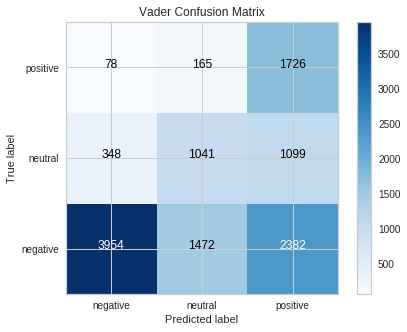

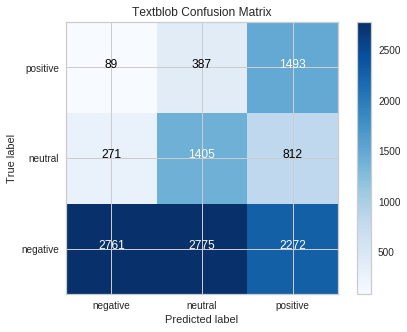

In [49]:
# CONFUSION MATRIX PLOT
def plot_confusion_matrix(method, cm, classes, normalize=False, cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylim([-0.5, 2.5])
    plt.title(method + " Confusion Matrix")
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


methods = ["Vader", "Textblob"]

for method in methods:
  target = tweets["airline_sentiment"]
  predicted_TextBlob = tweets["polarity_"+ method +"_string"]

  class_names = unique_labels(target, predicted_TextBlob)

  # Computing the confusion matrix
  cnf_matrix = confusion_matrix(target, predicted_TextBlob)
  np.set_printoptions(precision=2)

  # Ploting non-normalized confusion matrix
  fig, ax = plt.subplots(figsize=(7,5))
  plot_confusion_matrix(method, cnf_matrix, classes=class_names)
  fig.show()


#### 3.3) Precision & Recall Scores
**Precision Score** shows the ability of a classification model to return only relevant instances <br>
Precision Score = TP /TP + FP <br>
<br>
**Recall Score** shows the ability of a classification model to identify all relevant instances <br>
Precision Score = TP /TP + FN

#### 3.4) Scatter classification plot
TO DO: explain it
 - **Color:** Actual value `tweets["airline_sentiment"]`
 - **Size:** Total number of followers `tweets["Followers"]`
 - **X axes:** polarity computed by Textblob `tweets["polarity_Textblob"]`
 - **Y axes:**  = polarity computed by Vader `tweets["polarity_Vader"]`

Text(0.5, 0, 'TEXTBLOB Polarity')

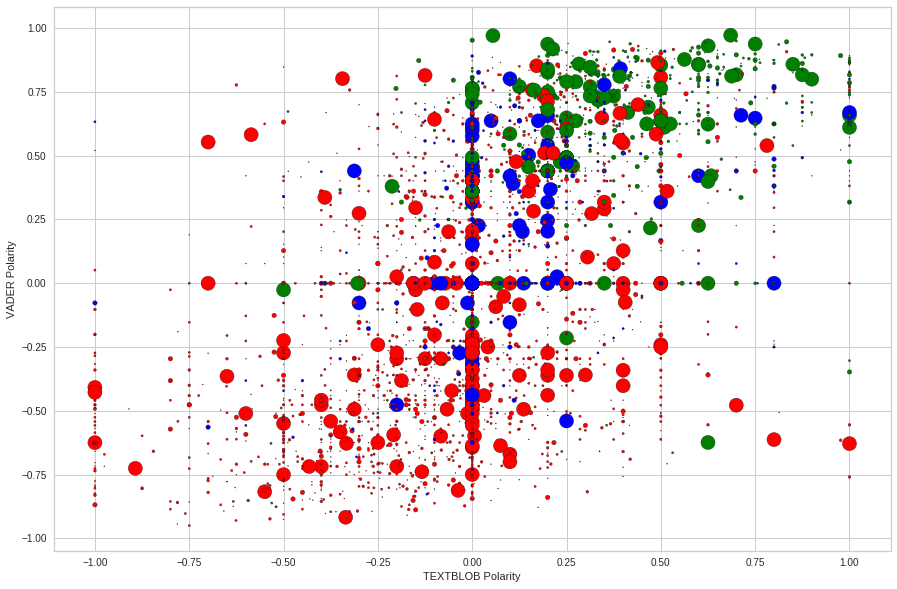

In [50]:
# Another way to visualize the error predicted by both methods, size dots = # followers
X = tweets["polarity_Textblob"]
y = tweets["polarity_Vader"]
followers = tweets["Followers"]
s = []
for t in followers:
  if t < 100:
    s.append(1)
  elif t < 500:
    s.append(5)
  elif t < 1500:
    s.append(8)
  elif t < 5000:
    s.append(20)
  else:
    s.append(200)

def scatter_plot(lst):
    cols=[]
    for l in lst:
        if l=='negative':
            cols.append('red')
        elif l=='neutral':
            cols.append('blue')
        else:
            cols.append('green')
    return cols

colors = scatter_plot(tweets["airline_sentiment"])
size = 5000
plt.figure(figsize=(15,10))
plt.scatter(X[:size], y[:size], c = colors[:size], edgecolors='k', s = s[:size])
plt.ylabel('VADER Polarity')
plt.xlabel('TEXTBLOB Polarity')

#### 3.5) The Major Matrix
The **Major Matrix** enables to store all the tweets wronlgy classified in the first attempt.

$$ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ Predicted \ \ Value $$
$$ Actual \ \ Value \  \begin{pmatrix}
0 & (5) \ a_{pos}\_p_{neu} & (2) \ a_{pos}\_p_{neg}\\
(3) \ a_{neu}\_p_{pos} & 0 & (6) \ a_{neu}\_p_{neg}\\
(1) \ a_{neg}\_p_{pos} & (4) \ a_{neg}\_p_{neu} & 0\\
\end{pmatrix}$$



In [0]:
# Defining the predicted and actual values
pred_TBlob = tweets["polarity_Textblob"]
pred_Vlder = tweets["polarity_Vader"]
act_sent = tweets[["airline_sentiment","text"]]

In [0]:
# Detecting and storing the incorrect tweets
def incorrect_predicted_tweets(actual_sentiment, predicted_sentiment):
  df = []
  for i in range(len(pred_Vlder)):
    if predicted_sentiment == "positive":
        if pred_Vlder[i] > 0 and act_sent.iloc[i,0] == actual_sentiment:
          df.append(act_sent.iloc[i,1])  
    elif predicted_sentiment == "neutral":
        if pred_Vlder[i]  == 0 and act_sent.iloc[i,0] == actual_sentiment:
          df.append(act_sent.iloc[i,1]) 
    else:   
      if pred_Vlder[i] < 0 and act_sent.iloc[i,0] == actual_sentiment:
        df.append(act_sent.iloc[i,1])
  return df

In [0]:
# Applying the incorrect_predicted_tweets formula for each type of error:
actual_predicted = {"aneu_ppos": ["neutral", "positive"], 
                    "aneg_pneu" : ["negative", "neutral"], 
                    "apos_pneu" : ["positive", "neutral"], 
                    "aneu_pneg" : ["neutral", "negative"], 
                    "aneg_ppos" : ["negative", "positive"], 
                    "apos_pneg" : ["positive", "negative"]}

wrong_tweets = {}
for key in actual_predicted:
  wrong_tweets[key] = incorrect_predicted_tweets(actual_predicted[key][0],actual_predicted[key][1])

# Creating a DataFrame for each tweet wrongly classified
df_wrong_tweets = pd.DataFrame(dict([ (k,pd.Series(v)) for k,v in wrong_tweets.items() ]))

If the reader wants to verify if the **`incorrect_predicted_tweets`** where correctly stored in the **Major Matrix** he can run the code below:
```python
print(len(df_wrong_tweets["apos_pneg"].dropna())) 
print(len(df_wrong_tweets["aneu_pneg"].dropna()))
print(len(df_wrong_tweets["apos_pneu"].dropna()))
print(len(df_wrong_tweets["aneg_pneu"].dropna()))
print(len(df_wrong_tweets["aneu_ppos"].dropna()))
print(len(df_wrong_tweets["aneg_ppos"].dropna()))
```

You will find that the lenght of each type of error is equal to the confusion matrix when is not normalized. For instance, The first line of code is equal to 78, which corresponds a **True value = positve** and **Predicted value = negative**

#### 3.6) The error types 

###### Error (1): *apos_pneg*
Tweets where the actual value is positive but Vader classified as negative:

> **Green dots ubicated in y < 0 in the Scatter calssification plot** 

**Spoiler!** TextBlob does not distinguish sarcasm or irony and have serious problems when have to classify *ambiguous words* such as "killed".

*Other examples:*
* less painful
* obsessed with
* it was absurd
* freaked me out
* fixed the broken ramp
* "*We left iPad in a seat pocket.  Filed lost item report. Received it exactly 1 week Late Flightr.  Is that a record?  #unbelievable*"

However, this is not a significant problem since represents de 1% of the total tweets...

---

In [54]:
for apos_pneg in df_wrong_tweets["apos_pneg"][0:5]:
  print(apos_pneg)

@virginamerica Well, I didn't…but NOW I DO! :-D
@VirginAmerica So excited for my first cross country flight LAX to MCO I've heard nothing but great things about Virgin America. #29DaysToGo
@VirginAmerica come back to #PHL already. We need you to take us out of this horrible cold. #pleasecomeback http://t.co/gLXFwP6nQH
@VirginAmerica twitter team. you guys killed it for rescheduling me asap. thank you!
@united he has no priority and Iove it


##### Error (2): *aneg_ppos*

(ii) Tweets where the actual value is negative but Vader classified as positive:

> **Red dots in the previous graph ubicated in y > 0** 

This is an important issue since 18% of total decisions using either the Textblob or Vader are made wrongly.

As we can observed in the printed tweeets from above, the TextBlob and Vader methods don't weight properly the words in the tweet. Let's take an example to understand what really is happening:

In [55]:
for aneg_ppos in df_wrong_tweets["aneg_ppos"][0:5]:
  print(aneg_ppos)

@VirginAmerica  I flew from NYC to SFO last week and couldn't fully sit in my seat due to two large gentleman on either side of me. HELP!
@united Usually an issue with Express our of SFO. Positive note: Mainline p.s. was enjoyable.
@VirginAmerica soooo are you guys going to leave the seatbelt light on all flight? You can barely call this turbulence :-)
@VirginAmerica amazing to me that we can't get any cold air from the vents. #VX358 #noair #worstflightever #roasted #SFOtoBOS
@VirginAmerica help, left expensive headphones on flight 89 IAD to LAX today. Seat 2A. No one answering L&amp;F number at LAX!


In [56]:
# Understanding the problem of Hastags
tweets_sample = ("moved my seat with no notice. Better seat is cabin select not behind the row I selected👎 #DISAPPOINTED",
                 "moved my seat with no notice. Better seat is cabin select not behind the row I selected👎 DISAPPOINTED", 
                 "why can't we book seats on your flights when we buy them or even during check in? Creates so much anxiety! #frustrated",
                 "why can't we book seats on your flights when we buy them or even during check in? Creates so much anxiety! frustrated")

# Computing the Vader polarity when "#" is removed:
print(sentiment_analysis(tweets_sample)["compound"])

0    0.1779
1   -0.4824
2    0.1062
3   -0.5905
Name: compound, dtype: float64


##### Error (3): *aneu_ppos*


In [57]:
for aneu_ppos in df_wrong_tweets["aneu_ppos"][0:5]:
  print(aneu_ppos)

@VirginAmerica Really missed a prime opportunity for Men Without Hats parody, there. https://t.co/mWpG7grEZP
@VirginAmerica do you miss me? Don't worry we'll be together very soon.
Nice RT @VirginAmerica: Vibe with the moodlight from takeoff to touchdown. #MoodlitMonday #ScienceBehindTheExperience http://t.co/Y7O0uNxTQP
@VirginAmerica plz help me win my bid upgrade for my flight 2/27 LAX---&gt;SEA!!!  🍷👍💺✈️
@VirginAmerica  DREAM http://t.co/oA2dRfAoQ2 http://t.co/lWWdAc2kHx


##### Error (4): *aneg_pneu*


In [58]:
for aneg_pneu in df_wrong_tweets["aneg_pneu"][0:5]:
  print(aneg_pneu)

@VirginAmerica why are your first fares in May over three times more than other carriers when all seats are available to select???
@VirginAmerica I called a 3-4 weeks ago about adding 3 flights from 2014 to my Elevate...they still haven't shown up...help!
@VirginAmerica Hi, Virgin! I'm on hold for 40-50 minutes -- are there any earlier flights from LA to NYC tonight; earlier than 11:50pm?
@virginamerica how's a direct flight FLL-&gt;SFO have unexpected layover in Vegas 4 fuel yet peeps next to me bought for Vegas flight. #sneaky
@VirginAmerica I’m having trouble adding this flight my wife booked to my Elevate account. Help? http://t.co/pX8hQOKS3R


##### Error (5): *apos_pneu*


In [59]:
for apos_pneu in df_wrong_tweets["apos_pneu"][0:5]:
  print(apos_pneu)

@VirginAmerica plus you've added commercials to the experience... tacky.
@VirginAmerica @virginmedia I'm flying your #fabulous #Seductive skies again! U take all the #stress away from travel http://t.co/ahlXHhKiyn
I ❤️ flying @VirginAmerica. ☺️👍
@VirginAmerica View of downtown Los Angeles, the Hollywood Sign, and beyond that rain in the mountains! http://t.co/Dw5nf0ibtr
@VirginAmerica you know it. Need it on my spotify stat #guiltypleasures


##### Error (6): *aneu_pneg*


In [60]:
for aneu_pneg in df_wrong_tweets["aneu_pneg"][0:5]:
  print(aneu_pneg)

@VirginAmerica will you be making BOS&gt;LAS non stop permanently anytime soon?
@VirginAmerica LAX to EWR - Middle seat on a red eye. Such a noob maneuver. #sendambien #andchexmix
@VirginAmerica Is flight 769 on it's way? Was supposed to take off 30 minutes ago. Website still shows "On Time" not "In Flight". Thanks.
@VirginAmerica @LadyGaga @CarrieUnderwood Sorry, Mary Martin had it first!
@VirginAmerica Flight 0736 DAL to DCA 2/24 2:10pm. Tried to check in could not. Status please.


The columns we need to focus are:
-  `polarity` which is the sentiment analysis using Textblob.
-  `compound` which is the sentiment analysis using Vader.

The lecturer will have noticed that when we have a *hastag* both methods do not take into account the word - i.e. *disappointed* and *frustrated*

This are one of the multiple problems that we want to solve. For that, in the next section we will try to apply the **N-GRAMS** approach. To do that, we need, first of all to tokenize the whole bunch of tweets.

---
TO DO: 
- Split hastags, specially the # with the word
- Intesify words: joke, help, wait, delayed, luggage, suitcase, turbulence

### 4) Reclassification

Here an example where the first 200 tweets from the dataframe `tweets` are filtered.


Having saw that now we want to increase the accuracy of TextBlob and Vader using the N-GRAMS. The **`ngrams`** function compute `bigrams = 2-grams` and `trigrams = 3-grams`.

In [0]:
def ngrams(input_list):
    #onegrams = input_list
    bigrams = [' '.join(t) for t in list(zip(input_list, input_list[1:]))]
    trigrams = [' '.join(t) for t in list(zip(input_list, input_list[1:], input_list[2:]))]
    return bigrams + trigrams


Here an example with the apos_pneg tweets. We'll see that we improve 33% from our previous rate we had before.

In [0]:
# Before computing the ngrams function we need to tockenized the tweet
apos_pneg_tockenized = tokenization_tweets(apos_pneg)
apos_pneg_ngrams = []
for tokens in apos_pneg_tockenized:
  apos_pneg_ngrams.append(ngrams(tokens))

In [0]:
# Then we join all the ngrams tockens as 1 string format
apos_pneg_ngrams2 = []
for tokens in apos_pneg_ngrams:
  apos_pneg_ngrams2.append(' '.join(tokens))

In [64]:
# Finally we compute the sentiment_analysis using the string created before
table = sentiment_analysis(apos_pneg_ngrams2)
ratio_improved = sum(table["compound"] > 0)/len(table["compound"])
print("Thanks to N_GRAMS we reclassifies {:.2%}".format(ratio_improved) + " of the total apos_pneg_ngrams well")

Thanks to N_GRAMS we reclassifies 0.00% of the total apos_pneg_ngrams well


#### 4.1) Search group function

The function **`search_group_classes`** allows the user to classify tweets by passangers classes:

**Context**:
From a business perspective, the company needs to prioritize which customer needs to be replied to firstly. The idea, is to create several classes and then sort based on priority. In the ideal world, this priority will be based on ticket price but this information cannot be inferred.

- The first approach is to classify into 2 classes: **business class** and **not business class** only using the tweet text (i.e.: type of words in the tweet, orthography, etc.)

- The second approach is to figure out what is the scope of the tweet. For instance, if the account is verified, or the complaint is made by a very popular account (with a lot of followers) the complaint needs to be dealt quickly. *(NOT IMPLEMENTED)*

**Arguments**: 
*   `airline_sentiment`: determines the sentiment analysis we want to work with. Possible values: `('positive', 'negative', 'neutral')` 
*   `list_words`: words that define the group class, i.e.`("business class|first class|priority|preference")`

In [0]:
def search_group_classes(airline_sentiment, list_words):
    df_neg = (tweets[tweets['airline_sentiment'] == airline_sentiment])
    list_tweets = df_neg["text"]

    output = []
    for tweet in list_tweets:
        if re.findall(list_words, tweet):
            output.append(tweet)

    return output

Here we want to gathered the **business class tweets** from the dataset `tweets`.

In [66]:
business_class = ("business class|first class|priority|preference") # TO DO: store it in the tweets dataframe
business_class_tweets = search_group_classes("negative", business_class)
for bc_tweet in business_class_tweets[0:10]:
    print(bc_tweet)

@VirginAmerica I need to register a service dog for a first class ticket from SFO &gt; Dulles. The phone queue is an hour or longer. Pls advise
@united thanks ^mr i got rebooked already but I lost my first class seat. Such is life.
@united only thing confusing me is why I lost priority boarding? I'm a mileage plus card member 😔
@united three delayed flights and missed connections on first class flights and not get any compensation for losing those seats...
@united - you rebooked me to UA1764 after UA 3883 was Cancelled Flightled. I paid for first class ticket - but new seat is 38E. Can you please fix!
@united your first class is a joke, compared to all the others I have flown, don't ask for extra peanuts... That's NOT allowed! @AirCanada
@united we've been seating for 5hrs inside flight UA936 at #IAD delayed. We've only been offered water &amp; cookies in business class. #failed
@united can you make sure I’m on the upgrade list for 2/23 EWR-PDX using my GPU priority? Got a weird email 

### 5) Train, test and validation

### 6) Model validation
 

### 7) Business model
Sorting the tweets that have to be replied firstly

### 8) The sentiment methods used

#### 8.1) Vader
**V**alence **A**ware **D**ictionary and s**E**ntiment **R**easoner is another popular rule-based library for sentiment analysis. Like TextBlob, it uses a sentiment lexicon that contains intensity measures for each word based on human-annotated labels. A key difference however, is that VADER was designed with a **focus on social media texts**. This means that it puts a lot of emphasis on rules that capture the essence of text typically seen on social media — for example, **short sentences with emojis**, **repetitive vocabulary** and copious use of **punctuation** (such as exclamation marks). Below are some examples of the sentiment intensity scores output by VADER.

In [67]:
vader = SentimentIntensityAnalyzer()
print(vader.polarity_scores("This was the best idea I've had in a long time."))
print(vader.polarity_scores("best idea time."))
print(vader.polarity_scores("This was the BEST idea I've had in a long time."))
print(vader.polarity_scores("This was the BEST idea I've had in a long time!"))
print(vader.polarity_scores("This was the BEST idea I've had in a long time!!!"))
print(vader.polarity_scores("This was the BEST, BEST idea I've had in a long time!!! :D :D"))
print(vader.polarity_scores("This was the WORST, WORST idea I've had in a long time!!! :( :("))

{'neg': 0.0, 'neu': 0.682, 'pos': 0.318, 'compound': 0.6369}
{'neg': 0.0, 'neu': 0.323, 'pos': 0.677, 'compound': 0.6369}
{'neg': 0.0, 'neu': 0.646, 'pos': 0.354, 'compound': 0.7125}
{'neg': 0.0, 'neu': 0.633, 'pos': 0.367, 'compound': 0.7371}
{'neg': 0.0, 'neu': 0.608, 'pos': 0.392, 'compound': 0.7788}
{'neg': 0.0, 'neu': 0.324, 'pos': 0.676, 'compound': 0.9675}
{'neg': 0.645, 'neu': 0.355, 'pos': 0.0, 'compound': -0.9541}


#### 8.2) TextBlob

In [68]:
print(TextBlob("This was the best idea I've had in a long time.").sentiment)
print(TextBlob("best idea time.").sentiment)
print(TextBlob("This was the BEST idea I've had in a long time.").sentiment)
print(TextBlob("This was the BEST idea I've had in a long time!").sentiment)
print(TextBlob("This was the BEST idea I've had in a long time!!!").sentiment)
print(TextBlob("This was the BEST, BEST idea I've had in a long time!!! :D :D").sentiment)
print(TextBlob("This was the WORST, WORST idea I've had in a long time!!! :( :(").sentiment)


Sentiment(polarity=0.475, subjectivity=0.35)
Sentiment(polarity=1.0, subjectivity=0.3)
Sentiment(polarity=0.475, subjectivity=0.35)
Sentiment(polarity=0.46875, subjectivity=0.35)
Sentiment(polarity=0.451171875, subjectivity=0.35)
Sentiment(polarity=0.78046875, subjectivity=0.6)
Sentiment(polarity=-0.71953125, subjectivity=0.8800000000000001)


## Tweet translation
We can imagine that airlines might have different customer support teams spead in different localizations. We can detect the language of the tweets posted and hence transfer them to the correct team. Otherwise, translating the tweets will allow any support team to understand the tweets. Also, if the tweets were in different languages it can make sense to translate them into English or any desired language.

In [69]:
#Detect languange
list_language = []
tweet_for_language = tweets["text"]
for element in tweet_for_language[:10]:
    which_language = TextBlob(element)
    which_language.detect_language()#Detect the blob's language using the Google Translate API.
    list_language.append(which_language.detect_language())
print(list_language)

['en', 'en', 'en', 'en', 'en', 'en', 'en', 'en', 'en', 'en']


In [70]:
#Translation
list_translations = []
for element in tweet_for_language[:10]:
    text_to_be_translated = TextBlob(element)
    text_to_be_translated.translate(to ='es')#Translates the blob to another language using the Google Translate API.
    list_translations.append(str(text_to_be_translated.translate(to ='es')))
print(list_translations)

['@VirginAmerica Lo que dijo @dhepburn.', '@VirginAmerica plus has agregado comerciales a la experiencia ... de mal gusto.', '@VirginAmerica es realmente agresivo lanzar "entretenimiento" desagradable en las caras de tus invitados & amp; tienen poco recurso', '@VirginAmerica y es algo realmente malo', '@VirginAmerica seriamente pagaría $ 30 por vuelo por asientos que no tenían este juego.\nes realmente lo único malo de volar VA', '@VirginAmerica No lo hice hoy ... ¡Debe significar que necesito hacer otro viaje!', '@VirginAmerica sí, casi cada vez que vuelo en VX este "gusano del oído" no desaparecerá :)', '@VirginAmerica Realmente perdí una oportunidad privilegiada para la parodia de Hombres sin Sombreros, allí. https://t.co/mWpG7grEZP', '@virginamerica Bueno, no lo hice ... ¡pero AHORA LO HAGO! :-RE', '@VirginAmerica fue increíble y llegó una hora antes. Eres muy bueno conmigo']


In [71]:
#Adding language and translation to tweets table
table_10_lines = tweets[:10]
table_10_lines["language_tweets"] = list_language
table_10_lines["translation_tweets"] = list_translations
print(table_10_lines)


   Unnamed: 0  ...                                 translation_tweets
0           0  ...              @VirginAmerica Lo que dijo @dhepburn.
1           1  ...  @VirginAmerica plus has agregado comerciales a...
2           2  ...  @VirginAmerica es realmente agresivo lanzar "e...
3           3  ...            @VirginAmerica y es algo realmente malo
4           4  ...  @VirginAmerica seriamente pagaría $ 30 por vue...
5           5  ...  @VirginAmerica No lo hice hoy ... ¡Debe signif...
6           6  ...  @VirginAmerica sí, casi cada vez que vuelo en ...
7           7  ...  @VirginAmerica Realmente perdí una oportunidad...
8           8  ...  @virginamerica Bueno, no lo hice ... ¡pero AHO...
9           9  ...  @VirginAmerica fue increíble y llegó una hora ...

[10 rows x 26 columns]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
